In [1]:
import pandas as pd
import numpy as np
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
import time
from time import sleep

def get_distance_from_paydays(date):
    end_of_month = date.daysinmonth
    distance_to_1st = 0 if date.day >=15 else 15 - date.day
    distance_to15th = 0 if date.day < 15 else end_of_month - date.day
    return distance_to_1st + distance_to15th

def std(x): return np.std(x)


In [2]:
df_train = pd.read_csv('../../dataset/train/train_converted.csv')
df_test  = pd.read_csv('../../dataset/test/test_converted.csv')


In [3]:
df_train.head(2)

,Z_MARCA,Z_GAMA,Z_MODELO,Z_DEPARTAMENTO,Z_PUNTO_VENTA,Z_WEEK,Demanda,Z_WEEK_DATE,Z_DAY,Z_MONTH,Z_YEAR
0,MAR_5,GAM_3,MOD_318,DEP_12,PVENT_26,SEMANA_01,0,2021-05-17,17,5,2021
1,MAR_3,GAM_1,MOD_305,DEP_1,PVENT_212,SEMANA_01,0,2021-05-17,17,5,2021


In [4]:
df_test.head(2)

,Z_MARCA,Z_GAMA,Z_MODELO,Z_DEPARTAMENTO,Z_PUNTO_VENTA,Z_WEEK,Demanda,Z_WEEK_DATE,Z_DAY,Z_MONTH,Z_YEAR
0,MAR_5,GAM_3,MOD_318,DEP_12,PVENT_26,SEMANA_51,NaN,2022-05-02,2,5,2022
1,MAR_3,GAM_1,MOD_305,DEP_1,PVENT_212,SEMANA_51,NaN,2022-05-02,2,5,2022


In [5]:
df_train = df_train[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE','Demanda']].groupby(['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE']).sum().reset_index()
df_test = df_test[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE','Demanda']].groupby(['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE']).sum().reset_index()
df_train.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)
df_test.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)


In [6]:


print('Creating date_block_num ...')
N_submission = df_test.shape[0]
N_sales      = df_train.shape[0]

print(df_train.shape,df_test.shape)
df_auxiliar = pd.concat([df_train,df_test])
df_auxiliar.replace([np.inf, -np.inf, np.nan],0,inplace=True)


dates = df_auxiliar['Z_WEEK'].unique()

date = df_auxiliar['Z_WEEK'].min()
maxi = df_auxiliar['Z_WEEK'].max()


dict_dates = {}
for idx,date in enumerate(dates):
    dict_dates[date] =idx
    
    
df_auxiliar['date_block_num'] = df_auxiliar['Z_WEEK'].replace(dict_dates)

df_train, df_test = df_auxiliar[:N_sales], df_auxiliar[N_sales:]
print(df_train.shape,df_test.shape)

df_train.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)
df_test.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)

print('Creating date_block_num completed!')


print('Preprocessing TRAINING DATASET ...')


df_train['Z_WEEK_DATE'] = pd.to_datetime(df_train['Z_WEEK_DATE'])
df_train['days_from_payday'] = df_train['Z_WEEK_DATE'].apply(get_distance_from_paydays)


statistics_columns = [ ]

bar1 = tqdm([
    ['Z_MODELO'],
    ['Z_PUNTO_VENTA'],
    ['Z_GAMA'],
    ['Z_MODELO','Z_PUNTO_VENTA'],
    ['Z_MODELO','Z_GAMA'],
    ['Z_PUNTO_VENTA','Z_GAMA'],
    ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']], position=0, desc="i",colour='green', ncols=80)
time.sleep(1)

bar2 = tqdm(['mean','std','max','min'], position=1, desc="j", colour='red', ncols=80, leave=False)
time.sleep(1)

unique_columns = [ ]
        
for column_names in bar1:
    bar1.update()
    bar2.refresh()  #force print final state
    bar2.reset()  #reuse bar
    time.sleep(0.1)
    for statistic in bar2:
        
        new_column_name = statistic+'_sales_by_'+'_'.join(column_names)
        #df_train[new_column_name] = df_train.groupby(["Z_WEEK_DATE"]+column_names, observed=True).Demanda.transform(statistic)
        if statistic == 'mean':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.mean()
        if statistic == 'std':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.std(ddof=0)
        if statistic == 'max':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.max()
        if statistic == 'min':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).Demanda.min()
        if df_agg.shape[0] >= df_train.shape[0]*0.7:
            unique_columns.append([["Z_WEEK"]+column_names,new_column_name])
            continue
        
        df_agg = df_agg.reset_index()
        df_agg.columns = df_agg.columns.str.replace('Demanda', new_column_name)
        
        df_train = df_train.merge(df_agg,on=["Z_WEEK"]+column_names,how='left')
        statistics_columns.append(new_column_name)
        bar2.update()
        time.sleep(0.05)
    
df_train['dayofweek'] = df_train['Z_WEEK_DATE'].dt.dayofweek.astype('str').astype('category')
df_train['month'] = df_train['Z_WEEK_DATE'].dt.month.astype('str').astype('category')
df_train['dayofyear'] = df_train['Z_WEEK_DATE'].dt.dayofyear.astype('str').astype('category')

df_train.drop(columns=['Z_WEEK_DATE'],inplace=True)
df_train.drop(columns=['Z_WEEK'],inplace=True)

print('Preprocessing TRAINING DATASET COMPLETED!')
print('Preprocessing TESTING DATASET ...')


df_test['Z_WEEK_DATE'] = pd.to_datetime(df_test['Z_WEEK_DATE'])
df_test['days_from_payday'] = df_test['Z_WEEK_DATE'].apply(get_distance_from_paydays)

inv_dict_dates = {v: k for k, v in dict_dates.items()}
#df_test['Z_WEEK'] = df_test['date_block_num'].map(inv_dict_dates)
df_test = df_test[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"Demanda","Z_WEEK_DATE"]]

df_test['dayofweek'] = df_test['Z_WEEK_DATE'].dt.dayofweek.astype('str').astype('category')
df_test['month'] = df_test['Z_WEEK_DATE'].dt.month.astype('str').astype('category')
df_test['dayofyear'] = df_test['Z_WEEK_DATE'].dt.dayofyear.astype('str').astype('category')



df_test['days_from_payday'] = df_test['Z_WEEK_DATE'].apply(get_distance_from_paydays)
df_test.drop(columns=['Z_WEEK_DATE'],inplace=True)

print('Preprocessing TESTING DATASET COMPLETED!')


Creating date_block_num ...
(2358650, 6) (471730, 6)
(2358650, 7) (471730, 7)


/tmp/ipykernel_934/1812446820.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)
/tmp/ipykernel_934/1812446820.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)


Creating date_block_num completed!
Preprocessing TRAINING DATASET ...


/tmp/ipykernel_934/1812446820.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Z_WEEK_DATE'] = pd.to_datetime(df_train['Z_WEEK_DATE'])
/tmp/ipykernel_934/1812446820.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['days_from_payday'] = df_train['Z_WEEK_DATE'].apply(get_distance_from_paydays)
j:  75%|███████████████████████████████▌          | 3/4 [00:01<00:00,  1.68it/s]
j: 5it [00:02,  1.92it/s]                                                       
j: 6it [00:03,  1.61it/s]
i: 1

Preprocessing TRAINING DATASET COMPLETED!
Preprocessing TESTING DATASET ...


/tmp/ipykernel_934/1812446820.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Z_WEEK_DATE'] = pd.to_datetime(df_test['Z_WEEK_DATE'])
/tmp/ipykernel_934/1812446820.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['days_from_payday'] = df_test['Z_WEEK_DATE'].apply(get_distance_from_paydays)


Preprocessing TESTING DATASET COMPLETED!


In [7]:
df_train.groupby(["date_block_num"]+['Z_MODELO','Z_GAMA'], observed=True).Demanda.std(ddof=0)

date_block_num  Z_MODELO  Z_GAMA
0               MOD_1     GAM_1     0.000000
                MOD_10    GAM_1     0.000000
                MOD_100   GAM_1     0.000000
                MOD_101   GAM_2     0.000000
                MOD_102   GAM_2     0.926386
                                      ...   
49              MOD_95    GAM_1     0.574438
                MOD_96    GAM_1     0.936901
                MOD_97    GAM_5     0.000000
                MOD_98    GAM_1     0.000000
                MOD_99    GAM_3     8.812424
Name: Demanda, Length: 15900, dtype: float64

In [8]:
unique_columns

[[['Z_WEEK', 'Z_MODELO', 'Z_PUNTO_VENTA'],
  'mean_sales_by_Z_MODELO_Z_PUNTO_VENTA'],
 [['Z_WEEK', 'Z_MODELO', 'Z_PUNTO_VENTA'],
  'std_sales_by_Z_MODELO_Z_PUNTO_VENTA'],
 [['Z_WEEK', 'Z_MODELO', 'Z_PUNTO_VENTA'],
  'max_sales_by_Z_MODELO_Z_PUNTO_VENTA'],
 [['Z_WEEK', 'Z_MODELO', 'Z_PUNTO_VENTA'],
  'min_sales_by_Z_MODELO_Z_PUNTO_VENTA'],
 [['Z_WEEK', 'Z_MODELO', 'Z_PUNTO_VENTA', 'Z_GAMA'],
  'mean_sales_by_Z_MODELO_Z_PUNTO_VENTA_Z_GAMA'],
 [['Z_WEEK', 'Z_MODELO', 'Z_PUNTO_VENTA', 'Z_GAMA'],
  'std_sales_by_Z_MODELO_Z_PUNTO_VENTA_Z_GAMA'],
 [['Z_WEEK', 'Z_MODELO', 'Z_PUNTO_VENTA', 'Z_GAMA'],
  'max_sales_by_Z_MODELO_Z_PUNTO_VENTA_Z_GAMA'],
 [['Z_WEEK', 'Z_MODELO', 'Z_PUNTO_VENTA', 'Z_GAMA'],
  'min_sales_by_Z_MODELO_Z_PUNTO_VENTA_Z_GAMA']]

In [9]:
df_train.info(verbose=True, null_counts=True)

/tmp/ipykernel_934/2159503274.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df_train.info(verbose=True, null_counts=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2358650 entries, 0 to 2358649
Data columns (total 29 columns):
 #   Column                              Non-Null Count    Dtype   
---  ------                              --------------    -----   
 0   Z_MODELO                            2358650 non-null  object  
 1   Z_PUNTO_VENTA                       2358650 non-null  object  
 2   Z_GAMA                              2358650 non-null  object  
 3   Demanda                             2358650 non-null  float64 
 4   date_block_num                      2358650 non-null  int64   
 5   days_from_payday                    2358650 non-null  int64   
 6   mean_sales_by_Z_MODELO              2358650 non-null  float64 
 7   std_sales_by_Z_MODELO               2358650 non-null  float64 
 8   max_sales_by_Z_MODELO               2358650 non-null  float64 
 9   min_sales_by_Z_MODELO               2358650 non-null  float64 
 10  mean_sales_by_Z_PUNTO_VENTA         2358650 non-null  float64 
 11

In [10]:
print(df_train.shape)
print(list(df_train.columns))
df_train.head(2)

(2358650, 29)
['Z_MODELO', 'Z_PUNTO_VENTA', 'Z_GAMA', 'Demanda', 'date_block_num', 'days_from_payday', 'mean_sales_by_Z_MODELO', 'std_sales_by_Z_MODELO', 'max_sales_by_Z_MODELO', 'min_sales_by_Z_MODELO', 'mean_sales_by_Z_PUNTO_VENTA', 'std_sales_by_Z_PUNTO_VENTA', 'max_sales_by_Z_PUNTO_VENTA', 'min_sales_by_Z_PUNTO_VENTA', 'mean_sales_by_Z_GAMA', 'std_sales_by_Z_GAMA', 'max_sales_by_Z_GAMA', 'min_sales_by_Z_GAMA', 'mean_sales_by_Z_MODELO_Z_GAMA', 'std_sales_by_Z_MODELO_Z_GAMA', 'max_sales_by_Z_MODELO_Z_GAMA', 'min_sales_by_Z_MODELO_Z_GAMA', 'mean_sales_by_Z_PUNTO_VENTA_Z_GAMA', 'std_sales_by_Z_PUNTO_VENTA_Z_GAMA', 'max_sales_by_Z_PUNTO_VENTA_Z_GAMA', 'min_sales_by_Z_PUNTO_VENTA_Z_GAMA', 'dayofweek', 'month', 'dayofyear']


,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,Demanda,date_block_num,days_from_payday,mean_sales_by_Z_MODELO,std_sales_by_Z_MODELO,max_sales_by_Z_MODELO,min_sales_by_Z_MODELO,...,std_sales_by_Z_MODELO_Z_GAMA,max_sales_by_Z_MODELO_Z_GAMA,min_sales_by_Z_MODELO_Z_GAMA,mean_sales_by_Z_PUNTO_VENTA_Z_GAMA,std_sales_by_Z_PUNTO_VENTA_Z_GAMA,max_sales_by_Z_PUNTO_VENTA_Z_GAMA,min_sales_by_Z_PUNTO_VENTA_Z_GAMA,dayofweek,month,dayofyear
0,MOD_1,PVENT_1,GAM_1,0.0,0,14,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,21.358696,76.613312,502.0,0.0,0,5,137
1,MOD_1,PVENT_1,GAM_1,0.0,1,7,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,26.217391,96.465113,708.0,0.0,0,5,144


In [11]:
df_train.shape

(2358650, 29)

In [12]:
print('statistics_columns : ',len(statistics_columns))
print(df_test.shape)
print(list(df_test.columns))
df_test.head(2)

statistics_columns :  20
(471730, 9)
['date_block_num', 'Z_MODELO', 'Z_PUNTO_VENTA', 'Z_GAMA', 'Demanda', 'dayofweek', 'month', 'dayofyear', 'days_from_payday']


,date_block_num,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,Demanda,dayofweek,month,dayofyear,days_from_payday
0,50,MOD_1,PVENT_1,GAM_1,0.0,0,5,122,13
1,51,MOD_1,PVENT_1,GAM_1,0.0,0,5,129,6


In [13]:
df_train[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','date_block_num','Demanda']][(df_train['Z_MODELO']=='MOD_10')&(df_train['date_block_num']==0)]

,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,date_block_num,Demanda
24050,MOD_10,PVENT_1,GAM_1,0,0.0
24100,MOD_10,PVENT_10,GAM_1,0,0.0
24150,MOD_10,PVENT_100,GAM_1,0,0.0
24200,MOD_10,PVENT_101,GAM_1,0,0.0
24250,MOD_10,PVENT_102,GAM_1,0,0.0
...,...,...,...,...,...
46650,MOD_10,PVENT_95,GAM_1,0,0.0
46700,MOD_10,PVENT_96,GAM_1,0,0.0
46750,MOD_10,PVENT_97,GAM_1,0,0.0
46800,MOD_10,PVENT_98,GAM_1,0,0.0


In [14]:
df_train["Z_MODELO"].value_counts()

MOD_1      24050
MOD_3      23950
MOD_2      23950
MOD_5      23500
MOD_4      23500
           ...  
MOD_294       50
MOD_295       50
MOD_296       50
MOD_297       50
MOD_287       50
Name: Z_MODELO, Length: 318, dtype: int64

In [15]:
df_train["Z_GAMA"].value_counts()

GAM_1    1039250
GAM_2     612450
GAM_3     278800
GAM_4     222650
GAM_5     185950
GAM_6      19500
GAM_7         50
Name: Z_GAMA, dtype: int64

In [16]:
for z_modelo in list(df_train["Z_MODELO"].value_counts().index.values)[:10]+['MOD_102']:
    aux = df_train[(df_train['Z_MODELO']==z_modelo)]['Z_GAMA'].value_counts()
    print('Z_MODELO = ',z_modelo,' # GAMAS =',aux.shape[0])

Z_MODELO =  MOD_1  # GAMAS = 1
Z_MODELO =  MOD_3  # GAMAS = 1
Z_MODELO =  MOD_2  # GAMAS = 1
Z_MODELO =  MOD_5  # GAMAS = 1
Z_MODELO =  MOD_4  # GAMAS = 1
Z_MODELO =  MOD_7  # GAMAS = 1
Z_MODELO =  MOD_6  # GAMAS = 1
Z_MODELO =  MOD_8  # GAMAS = 1
Z_MODELO =  MOD_9  # GAMAS = 1
Z_MODELO =  MOD_10  # GAMAS = 1
Z_MODELO =  MOD_102  # GAMAS = 1


In [17]:
for z_modelo in list(df_train["Z_MODELO"].value_counts().index.values)[:10]+['MOD_102']:
    aux = df_train[(df_train['Z_MODELO']==z_modelo)]['Z_PUNTO_VENTA'].value_counts()
    print('Z_MODELO = ',z_modelo,' # Z_PUNTO_VENTA =',aux.shape[0])

Z_MODELO =  MOD_1  # Z_PUNTO_VENTA = 481
Z_MODELO =  MOD_3  # Z_PUNTO_VENTA = 479
Z_MODELO =  MOD_2  # Z_PUNTO_VENTA = 479
Z_MODELO =  MOD_5  # Z_PUNTO_VENTA = 470
Z_MODELO =  MOD_4  # Z_PUNTO_VENTA = 470
Z_MODELO =  MOD_7  # Z_PUNTO_VENTA = 463
Z_MODELO =  MOD_6  # Z_PUNTO_VENTA = 463
Z_MODELO =  MOD_8  # Z_PUNTO_VENTA = 462
Z_MODELO =  MOD_9  # Z_PUNTO_VENTA = 462
Z_MODELO =  MOD_10  # Z_PUNTO_VENTA = 457
Z_MODELO =  MOD_102  # Z_PUNTO_VENTA = 226


In [18]:
df_train[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','date_block_num','Demanda']][(df_train['Z_MODELO']=='MOD_10')]['Z_GAMA'].value_counts()

GAM_1    22850
Name: Z_GAMA, dtype: int64

In [19]:
aux = df_train["Z_MODELO"].astype(str) + df_train["Z_GAMA"]
aux.value_counts()

MOD_1GAM_1      24050
MOD_3GAM_4      23950
MOD_2GAM_1      23950
MOD_5GAM_1      23500
MOD_4GAM_1      23500
                ...  
MOD_294GAM_2       50
MOD_295GAM_3       50
MOD_296GAM_4       50
MOD_297GAM_3       50
MOD_287GAM_1       50
Length: 318, dtype: int64

In [20]:
df_train[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','date_block_num','Demanda']][(df_train['Z_MODELO']=='MOD_10')&(df_train['Z_PUNTO_VENTA']=='PVENT_1')]

,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,date_block_num,Demanda
24050,MOD_10,PVENT_1,GAM_1,0,0.0
24051,MOD_10,PVENT_1,GAM_1,1,0.0
24052,MOD_10,PVENT_1,GAM_1,2,0.0
24053,MOD_10,PVENT_1,GAM_1,3,0.0
24054,MOD_10,PVENT_1,GAM_1,4,0.0
24055,MOD_10,PVENT_1,GAM_1,5,0.0
24056,MOD_10,PVENT_1,GAM_1,6,0.0
24057,MOD_10,PVENT_1,GAM_1,7,0.0
24058,MOD_10,PVENT_1,GAM_1,8,0.0
24059,MOD_10,PVENT_1,GAM_1,9,0.0


In [21]:
df_train[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','date_block_num','Demanda']][(df_train['Z_MODELO']=='MOD_10')&(df_train['Z_PUNTO_VENTA']=='PVENT_1')&(df_train['date_block_num']==10)]

,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,date_block_num,Demanda
24060,MOD_10,PVENT_1,GAM_1,10,0.0


In [22]:
df_train[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','date_block_num','Demanda']][(df_train['Z_MODELO']=='MOD_10')&(df_train['Z_PUNTO_VENTA']=='PVENT_2')]

,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,date_block_num,Demanda
29600,MOD_10,PVENT_2,GAM_1,0,0.0
29601,MOD_10,PVENT_2,GAM_1,1,0.0
29602,MOD_10,PVENT_2,GAM_1,2,0.0
29603,MOD_10,PVENT_2,GAM_1,3,0.0
29604,MOD_10,PVENT_2,GAM_1,4,0.0
29605,MOD_10,PVENT_2,GAM_1,5,0.0
29606,MOD_10,PVENT_2,GAM_1,6,0.0
29607,MOD_10,PVENT_2,GAM_1,7,0.0
29608,MOD_10,PVENT_2,GAM_1,8,0.0
29609,MOD_10,PVENT_2,GAM_1,9,0.0


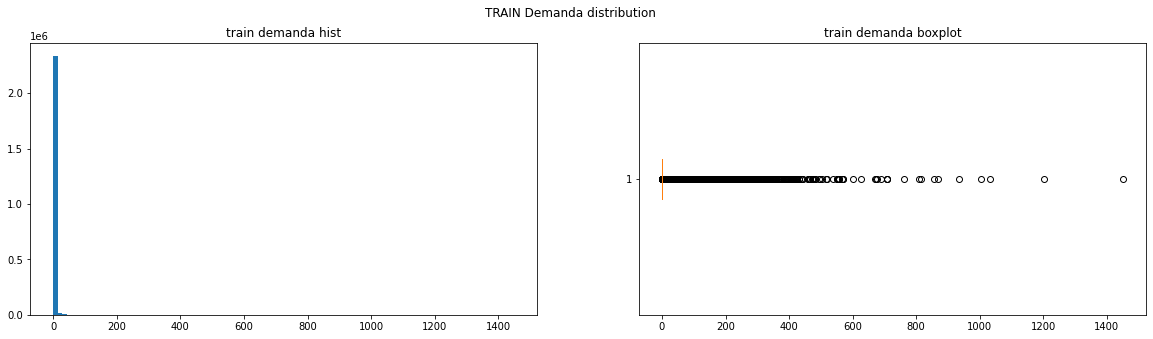

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.hist(df_train['Demanda'],bins=100)
plt.title('train demanda hist')
plt.subplot(1,2,2)
plt.boxplot(df_train['Demanda'],vert=False)
plt.title('train demanda boxplot')
plt.suptitle('TRAIN Demanda distribution')
plt.show()

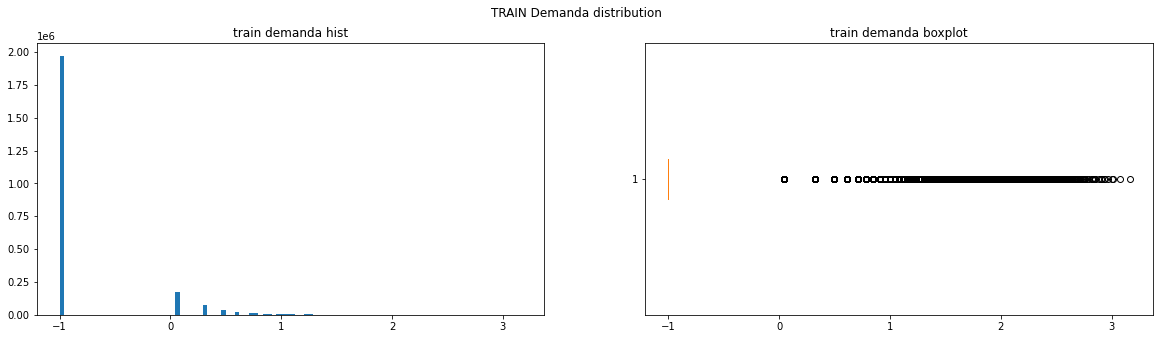

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.hist(np.log10(df_train['Demanda']+0.1),bins=100)
plt.title('train demanda hist')
plt.subplot(1,2,2)
plt.boxplot(np.log10(df_train['Demanda']+0.1),vert=False)
plt.title('train demanda boxplot')
plt.suptitle('TRAIN Demanda distribution')
plt.show()

In [25]:
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer,EncoderNormalizer

from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
"""Point metrics for forecasting a single point per time step."""
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.metrics import SMAPE, MAE,RMSE

import scipy.stats
import torch
import torch.nn.functional as F
from torch.nn.utils import rnn

from pytorch_forecasting.metrics import MultiHorizonMetric
from pytorch_forecasting.utils import create_mask, unpack_sequence, unsqueeze_like

from typing import Any, Callable, Dict, List, Optional, Tuple, Union



import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
# configure network and trainer
pl.seed_everything(42)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
Global seed set to 42


In [26]:
prediction_steps = df_test['date_block_num'].nunique()
prediction_steps

10

In [27]:
df_train['date_block_num'].nunique()

50

In [28]:
#'day_of_week', 'day', 'is_month_end', 'day_of_year',  'is_quarter_start', 'year', 'month', 'is_year_start', 'is_month_start', 
# 'I103','S103', 'C101','I100' , 'C100', 'ID', 'I102','S102',, 'S101', 'S100', 'item_id', 'date_block_num', 'I101'
max_prediction_length = prediction_steps

max_encoder_length = 40

training_cutoff = df_train['date_block_num'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_train[lambda x: x['date_block_num'] <= training_cutoff],
    time_idx='date_block_num',
    target="Demanda",
    group_ids=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],
    min_encoder_length= max_encoder_length // 2,   
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
        
    static_categoricals=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],
    
    time_varying_unknown_categoricals=[
                                     "month", 
                                     "dayofweek",
                                     "dayofyear"],
    
    time_varying_unknown_reals=["date_block_num",'days_from_payday'],
                                #["date_block_num","Demanda"],
    time_varying_known_categoricals=[],  

    time_varying_known_reals= statistics_columns,#'date_block_num'],
       
    target_normalizer=GroupNormalizer(
        groups=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'], transformation="softplus"
    ),  # use softplus and normalize by group    
    
    categorical_encoders={
        #"Z_MARCA": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          
                          "Z_GAMA":  pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "Z_MODELO": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          #"Z_DEPARTAMENTO": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "Z_PUNTO_VENTA": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "dayofweek": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "dayofyear": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                         #"date_block_num": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                         },
    #,
    #                      "item_id":pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #                     },
    #'day_of_week', 'day', 'is_month_end', 'day_of_year',  'is_quarter_start', 'year', 'month', 'is_year_start', 'is_month_start']},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

In [29]:
validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)

In [30]:
batch_size = 128

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader   = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [31]:
import pytorch_lightning as pl
from pytorch_forecasting.metrics import QuantileLoss

pytorch_forecasting.metrics.point.TweedieLoss

pytorch_forecasting.metrics.point.TweedieLoss

In [32]:
from pytorch_forecasting.metrics import TweedieLoss


In [33]:
#from pytorch_forecasting.metrics.point import TweedieLoss

Baseline

In [34]:
if True:
    import pickle

    from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

    # create study
    study = optimize_hyperparameters(
        train_dataloader,
        val_dataloader,
        model_path="optuna_test",
        n_trials=10,
        max_epochs=20,
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=(8, 64),
        hidden_continuous_size_range=(8, 64),
        attention_head_size_range=(1, 4),
        learning_rate_range=(0.001, 0.1),
        dropout_range=(0.1, 0.3),
        trainer_kwargs=dict(limit_train_batches=30, log_every_n_steps=15, gpus=1),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=True,  # use Optuna to find ideal learning rate or use in-built learning rate finder
        timeout=300,
        #loss=QuantileLoss()
        loss=RMSE()
        #loss=TweedieLoss(p=1.1)
    )



    # show best hyperparameters
    print(study.best_trial.params)

[I 2022-08-05 07:10:20,660] A new study created in memory with name: no-name-267a6f8c-953c-4dd2-93dd-08abcaf389b9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]
Restoring states from the checkpoint path at /notebooks/entel-2022/DATATHON-ENTEL-2022---Reto2/notebooks/cristian/.lr_find_60a61b99-c204-47fe-81b3-32e02bfa8bb2.ckpt
[I 2022-08-05 07:11:23,004] Using learning rate of 0.00479
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=20` reached.
[I 2022-08-05 07:35:40,771] Trial 0 finished with value: 3.2069363594055176 and parameters: {'gradient_clip_val': 0.049151528852465355, 'hidden_size': 

{'gradient_clip_val': 0.049151528852465355, 'hidden_size': 45, 'dropout': 0.1269481992555201, 'hidden_continuous_size': 10, 'attention_head_size': 3, 'learning_rate': 0.0047863009232263845}


In [48]:
#Early Stopping 
MIN_DELTA  = 1e-4
PATIENCE   = 30

#PL Trainer
MAX_EPOCHS = 10000
GPUS = 1

if True:
    GRADIENT_CLIP_VAL=study.best_trial.params['gradient_clip_val']
    LIMIT_TRAIN_BATCHES=30

    #Fusion Transformer
    LR = study.best_trial.params['learning_rate']
    HIDDEN_SIZE = study.best_trial.params['hidden_size']
    DROPOUT = study.best_trial.params['dropout']
    ATTENTION_HEAD_SIZE = study.best_trial.params['attention_head_size']
    HIDDEN_CONTINUOUS_SIZE = study.best_trial.params['hidden_continuous_size']
    
    

else:

    #study = {'gradient_clip_val': 0.5899880996240897, 'hidden_size': 24, 'dropout': 0.18045896986283255, 
    # 'hidden_continuous_size': 11, 'attention_head_size': 2, 'learning_rate': 0.012427775478680268}
    
    study = {'gradient_clip_val': 0.3468483254885978, 'hidden_size': 32, 'dropout': 0.11031796015695508, 
            'hidden_continuous_size': 19, 'attention_head_size': 15, 'learning_rate': 0.04289257757804779}
    
    GRADIENT_CLIP_VAL=study['gradient_clip_val']
    LIMIT_TRAIN_BATCHES=30

    #Fusion Transformer
    LR = study['learning_rate']
    HIDDEN_SIZE = study['hidden_size']
    DROPOUT = study['dropout']
    ATTENTION_HEAD_SIZE = study['attention_head_size']
    HIDDEN_CONTINUOUS_SIZE = study['hidden_continuous_size']
    
OUTPUT_SIZE= 1
REDUCE_ON_PLATEAU_PATIENCE=5

In [49]:
ATTENTION_HEAD_SIZE

3

In [50]:
max_prediction_length

10

In [51]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=MIN_DELTA, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gpus=GPUS,
    #weights_summary="top",
    gradient_clip_val=GRADIENT_CLIP_VAL,
    limit_train_batches=LIMIT_TRAIN_BATCHES,#oment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    log_every_n_steps=10
    
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LR,
    hidden_size=HIDDEN_SIZE,
    attention_head_size=ATTENTION_HEAD_SIZE,
    dropout=DROPOUT,
    hidden_continuous_size=HIDDEN_CONTINUOUS_SIZE,
    output_size=OUTPUT_SIZE,# 7 quantiles by default
    
    #loss=QuantileLoss(),
    loss=RMSE(),
    #loss=TweedieLoss(p=1.1),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=REDUCE_ON_PLATEAU_PATIENCE,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 225.4k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
#TweedieLoss p=1.9  Epoch 0: 100%|██████████| 49/49 [01:24<00:00,  1.72s/it, loss=1.11e+04, v_num=19, train_loss_step=10.70, val_loss=6.19e+8, train_loss_epoch=8.9e+12]
#TweedieLoss p=1.01 Epoch 0: 100%|██████████| 49/49 [01:25<00:00,  1.74s/it, loss=1.66e+04, v_num=20, train_loss_step=110.0, val_loss=2.37e+19, train_loss_epoch=1.05e+21]



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 35.3 K
3  | prescalers                         | ModuleDict                      | 520   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 43.8 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 37.4 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 8.4 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 8.4 K 
9  | static_context_initial_cell_lstm 

Epoch 0:  45%|████▍     | 30/67 [00:15<00:19,  1.94it/s, loss=2.55, v_num=32, train_loss_step=1.630]
                                       
Epoch 1:  45%|████▍     | 30/67 [00:16<00:19,  1.87it/s, loss=3.68, v_num=32, train_loss_step=2.060, val_loss=3.220, train_loss_epoch=3.650]
Validation: 0it [00:00, ?it/s]
Epoch 2:  45%|████▍     | 30/67 [00:15<00:19,  1.88it/s, loss=4.58, v_num=32, train_loss_step=1.330, val_loss=3.210, train_loss_epoch=3.650]
Validation: 0it [00:00, ?it/s]
Epoch 3:  45%|████▍     | 30/67 [00:16<00:20,  1.83it/s, loss=2.66, v_num=32, train_loss_step=2.840, val_loss=3.210, train_loss_epoch=4.200]
Validation: 0it [00:00, ?it/s]
Epoch 4:  45%|████▍     | 30/67 [00:16<00:19,  1.87it/s, loss=6.04, v_num=32, train_loss_step=3.600, val_loss=3.210, train_loss_epoch=2.910]
Validation: 0it [00:00, ?it/s]
Epoch 5:  45%|████▍     | 30/67 [00:16<00:19,  1.87it/s, loss=3.56, v_num=32, train_loss_step=5.470, val_loss=3.210, train_loss_epoch=5.390]
Validation: 0it [00:00, ?it/s]

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(best_model_path)


In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print('hola')

In [ ]:
for idx in range(5):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [ ]:
# calcualte root mean squared error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_predictions = best_tft.predict(val_dataloader)

In [ ]:
criterion = nn.MSELoss()
rmse_val = torch.sqrt(criterion(actuals,val_predictions)).item()
print('rmse_val = ',rmse_val)

In [ ]:
for i in range(1):
    print(actuals[i],val_predictions[i])

In [ ]:
print('max_prediction_length:',max_prediction_length)
print('max_encoder_length   :',max_encoder_length)

In [ ]:
# select last 30 days from data (max_encoder_length is 24)
encoder_data = df_train[lambda x: x.date_block_num > x.date_block_num.max() - max_encoder_length]

print(encoder_data['date_block_num'].min(),encoder_data['date_block_num'].max())
#print(encoder_data['DATE'].min(),encoder_data['DATE'].max())
encoder_data

In [ ]:
df_test

In [ ]:
df_train.columns

In [ ]:
max_prediction_length

In [ ]:

last_data = df_train[df_train['date_block_num'].isin([idx  -  max_prediction_length for idx in df_test['date_block_num'].unique()])]
last_data['date_block_num'] = last_data['date_block_num'] + max_prediction_length

decoder_data = pd.merge(df_test[[col for col in df_test.columns if 'Demanda' not in col]], 
        last_data[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"Demanda"]+statistics_columns],
        on = ['date_block_num', 'Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',],
                        how='left'
        )


encoder_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)
decoder_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)


# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
last_data[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"Demanda"]+statistics_columns]

In [ ]:
import matplotlib.pyplot as plt

aux = encoder_data['Demanda'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

aux = decoder_data['Demanda'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()

In [ ]:
decoder_data

In [ ]:
new_prediction_data

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

In [ ]:
interpretation = best_tft.interpret_output(new_raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
df_test.head()

In [ ]:
new_raw_predictions = best_tft.predict(new_prediction_data, mode="prediction", return_x=False)


In [ ]:
predictions = pd.DataFrame(new_raw_predictions.numpy()).T
predictions['date_block_num'] = sorted(df_test['date_block_num'].unique())
predictions = pd.melt(predictions, id_vars=['date_block_num'])
predictions = predictions.sort_values(['date_block_num', 'variable']).reset_index(drop=True)
df_test[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']].sort_values(['date_block_num', 'Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']).reset_index(drop=True)
df_test2 = df_test.join(predictions['value'])

In [ ]:
df_test2.head()

In [ ]:
import pickle

reverse_mapping_file = '../../utils/reverse_dict_mapping_list.txt'

with open(reverse_mapping_file, 'rb') as f:
    reverse_mapping = pickle.load( f)

In [ ]:
#reverse_mapping#

In [ ]:
#descriptive_columns = ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']
descriptive_columns = ['Z_MARCA', 'Z_GAMA', 'Z_MODELO',
                       'Z_DEPARTAMENTO', 'Z_PUNTO_VENTA']
i=0
for column in descriptive_columns:
    if column in df_test2.columns:
        df_test2[column] = df_test2[column].map(reverse_mapping[i])
    i+=1

In [ ]:
df_test2.head()

In [ ]:

inv_dict_dates = {v: k for k, v in dict_dates.items()}
df_test2['Z_WEEK'] = df_test2['date_block_num'].map(inv_dict_dates)

In [ ]:
df_test2['ID'] = df_test2['Z_MODELO'] + '|' + df_test2['Z_PUNTO_VENTA'] + '|' + df_test2['Z_GAMA'] + '|' + df_test2['Z_WEEK']

In [ ]:
df_test2['Demanda'] = np.maximum(df_test2['value'],0)
submission = df_test2[['Z_WEEK','ID','Demanda']]#.groupby('ID').sum().reset_index()

In [ ]:
submission.head(1)

In [ ]:
submission.boxplot(['Demanda'])

In [ ]:
import matplotlib.pyplot as plt

aux = df_train['Demanda'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'go')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

prediction = submission['Demanda'].values
df_baseline = pd.read_csv('../../results/Submission_37.csv')
real = df_baseline['Demanda']

fig = plt.figure(figsize=(30,5))

plt.subplot(3,1,1)
plt.plot(prediction,'bo')
plt.title('prediction')


plt.subplot(3,1,2)
plt.plot(real,'go')
plt.title('real')

plt.subplot(3,1,3)
plt.plot(prediction,'bo',alpha=0.7,label='prediction')
plt.plot(real,'go',alpha=0.1,label='real')
plt.title('real')

plt.suptitle('analysis de predicciones')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

y_actual = df_baseline['Demanda']
y_predicted = submission['Demanda'].values

rms = mean_squared_error(y_actual, y_predicted, squared=False)
rms

In [ ]:
#rmse_val = 3
submission['Demanda_real'] = df_baseline['Demanda']

import plotly.express as px

tendencia_semanal = submission[['Z_WEEK','Demanda','Demanda_real']].groupby(['Z_WEEK']).sum().reset_index()

graph = pd.melt(tendencia_semanal,id_vars=['Z_WEEK'],value_vars=['Demanda','Demanda_real'],)

#fig = px.line(graph,x='date_block_num',y='value',color='variable')
#fig.show()
import seaborn as sns

sns.catplot(x="Z_WEEK", y="value", hue="variable", kind="point", data=graph, height=4.27, aspect=19.7/8.27)


In [ ]:
#submission['Demanda'] = 0.9#submission['value']
import numpy as np

submission[['ID', 'Demanda']].to_csv('../../results/Submission_tft_rmse_epoch100_val_'+str(np.round(rmse_val,2))+'_refencia_best_pred_rmse_'+str(np.round(rms,2))+'.csv', index = False, sep = ',')

In [ ]:
submission.head(1)